# Quick Start

Your user account:

* [User account](https://quantnet.ai/personalpage/homepage)

Documentation:

* [Documentation](https://quantnet.ai/documentation/en/)


**Strategy idea:** We will open positions on 500 liquid stocks when two moving averages of the closing cross each. The algorithm will create positive allocation weights for long positions (buy) and negative ones for short positions (sell).


# The full code
```python
import xarray as xr
import qnt.ta as qnta
import qnt.data as qndata
import qnt.output as qnout
import qnt.stats as qnstats

data = qndata.stocks.load_data(tail=5 * 365, dims=("time", "field", "asset"))

close = data.sel(field="close")
sma_slow = qnta.sma(close, 200)
sma_fast = qnta.sma(close, 20)
weights = xr.where(sma_slow < sma_fast, 1, -1)
weights = weights / len(data.asset)

weights = qnout.clean(weights, data)
qnout.check(weights, data)
qnout.write(weights)

stats = qnstats.calc_stat(data, weights)
stats.to_pandas().tail()
```

# The detailed steps

## 1. Preparation

We prepare our workspace importing the needed libraries and loading the data:

In [1]:
import xarray as xr

import qnt.ta as qnta
import qnt.data as qndata
import qnt.output as qnout
import qnt.stats as qnstats

data = qndata.stocks.load_data(tail=5 * 365, dims=("time", "field", "asset"))
display(data)

fetched chunk 1/7 0s
fetched chunk 2/7 0s
fetched chunk 3/7 0s
fetched chunk 4/7 0s
fetched chunk 5/7 0s
fetched chunk 6/7 1s
fetched chunk 7/7 1s
Data loaded 1s


<xarray.DataArray 'stocks' (time: 1257, field: 9, asset: 1060)>
array([[[1.62000e+00, 5.61800e-01, 3.06000e-02, ..., 9.80800e+01,
         1.95200e+01, 4.10800e+01],
        [1.62000e+00, 5.50000e-01, 3.00000e-02, ..., 9.78400e+01,
         1.90100e+01, 4.06150e+01],
        [1.74000e+00, 5.85000e-01, 3.20000e-02, ..., 9.98300e+01,
         1.98500e+01, 4.13200e+01],
        ...,
        [1.00000e+00, 1.00000e+00, 1.00000e+00, ..., 1.00000e+00,
         1.00000e+00, 1.00000e+00],
        [1.00000e+00, 1.00000e+00, 1.00000e-01, ..., 1.00000e+00,
         1.00000e+00, 1.00000e+00],
        [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
         0.00000e+00, 1.00000e+00]],

       [[1.65000e+00, 5.60000e-01, 3.30000e-02, ..., 9.84600e+01,
         1.96600e+01, 4.06000e+01],
        [1.65000e+00, 5.60000e-01, 3.10000e-02, ..., 9.83900e+01,
         1.95000e+01, 4.04600e+01],
        [1.75000e+00, 5.95000e-01, 3.30000e-02, ..., 1.00720e+02,
         2.03400e+01, 4.14300e+01],
...
        [        nan,         nan,         nan, ..., 1.00000e+00,
         1.00000e+00, 1.00000e+00],
        [        nan,         nan,         nan, ..., 1.00000e+00,
         1.00000e+00, 1.00000e+00],
        [        nan,         nan,         nan, ..., 1.00000e+00,
         1.00000e+00, 1.00000e+00]],

       [[        nan,         nan,         nan, ..., 1.63330e+02,
         1.50500e+02, 1.58390e+02],
        [        nan,         nan,         nan, ..., 1.60190e+02,
         1.47730e+02, 1.55530e+02],
        [        nan,         nan,         nan, ..., 1.63710e+02,
         1.51320e+02, 1.59550e+02],
        ...,
        [        nan,         nan,         nan, ..., 1.00000e+00,
         1.00000e+00, 1.00000e+00],
        [        nan,         nan,         nan, ..., 1.00000e+00,
         1.00000e+00, 1.00000e+00],
        [        nan,         nan,         nan, ..., 1.00000e+00,
         1.00000e+00, 1.00000e+00]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-03-04 2016-03-07 ... 2021-03-02
  * asset    (asset) <U12 'AMEX:APT' 'AMEX:IBIO' ... 'NYSE:ZEN' 'NYSE:ZTS'
  * field    (field) object 'open' 'low' 'high' ... 'split_cumprod' 'is_liquid'

The variable **data** is an xarray.DataArray  structure that contains historical market data for the last (tail=5 * 365) days whose coordinates are: 

* **time**: a date in format yyyy-mm-dd;
* **field**: an attribute, for example the opening daily price;
* **asset**: the identifying symbol for the asset, for example **NASDAQ:AAPL** for Apple stock.

More details on xarray can be found at https://xarray.pydata.org/en/stable/

## 2. Strategy. Weights allocation
For each date, 
the algorithm calculates what portfolio weights should be at the opening of the next day's trading.

Quantiacs uses an exposure-based backtester. The trading algorithm should define the fractions of capital which will be distributed to the assets (allocation weights). A **positive** weight means a long position (**buy**), a **negative** value means a short position (**sell**).

> Note that algorithm decisions can use all data available at the close of the session, and will be applied at the opening of the next day's session. The chosen allocation weights are translated to positions (number of contracts to be bought/sold) immediately after the close of the session and transactions are executed at the open of the next day.

> **Strategy idea**: We will open positions on 500 liquid stocks when two moving averages of the closing cross each. The algorithm will create positive allocation weights for long positions (buy) and negative ones for short positions (sell).


In [2]:
close = data.sel(field="close")
sma_slow = qnta.sma(close, 200)
sma_fast = qnta.sma(close, 20)
weights = xr.where(sma_slow < sma_fast, 1, -1)
weights = weights / len(data.asset)

The function "**clean**" **removes** the main financial **risks** from the strategy 

and helps to pass the platform filters

for more details - see the source code of the library **/qnt/output.py**

In [3]:
weights = qnout.clean(weights, data)

ffill if the current price is None...
Check liquidity...
ERROR! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Check exposure...
Ok. The exposure check succeed.
Normalization...
Done.


# 3. Performance estimation

After we have built the algorithm, we can evaluate its performance calculating statistics.

We can display the values of statistical indicators on a cumulative basis, assuming that we have 1M USD at the starting point.


In [4]:
stats = qnstats.calc_stat(data, weights)
stats.to_pandas().tail()

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2021-02-24,0.883812,0.007103,0.056022,-0.116983,-0.219578,-0.436224,-0.024438,0.706390,1051.0,0.017866,74.990106
2021-02-25,0.873668,-0.011478,0.056230,-0.127118,-0.219578,-0.474306,-0.026670,0.696552,1051.0,0.017866,74.982476
2021-02-26,0.873845,0.000202,0.056208,-0.126942,-0.219578,-0.473421,-0.026610,0.686207,1051.0,0.017867,74.977822
2021-03-01,0.883773,0.011361,0.056419,-0.117023,-0.219578,-0.432287,-0.024389,0.701906,1060.0,0.017865,74.980232
2021-03-02,0.879436,-0.004907,0.056437,-0.121355,-0.219578,-0.448777,-0.025328,0.706485,1060.0,0.017944,78.379405


The call will produce:

* **equity**: the cumulative value of profits and losses since inception (1M USD);
* **relative_return**: the relative daily variation of **equity**;
* **volatility**: the volatility of the investment since inception (i.e. the annualized standard deviation of the daily returns);
* **underwater**: the time evolution of drawdowns;
* **max_drawdown**: the absolute minimum of the underwater chart;
* **sharpe_ratio**: the annualized Sharpe ratio since inception; the value must be larger than 1 for taking part to contests;
* **mean_return**: the annualized mean return of the investment since inception;
* **bias**: the daily asymmetry between long and short exposure: 1 for a long-only system, -1 for a short-only one;
* **instruments**: the number of instruments which get allocations on a given day;
* **avg_turnover**: the average turnover;
* **avg_holding_time**: the average holding time in days.

A detailed explanation can be found inspecting th source code for the library in your directory at **/qnt/stats.py**

Moreover we can produce a chart which shows the cumulative profits and losses:

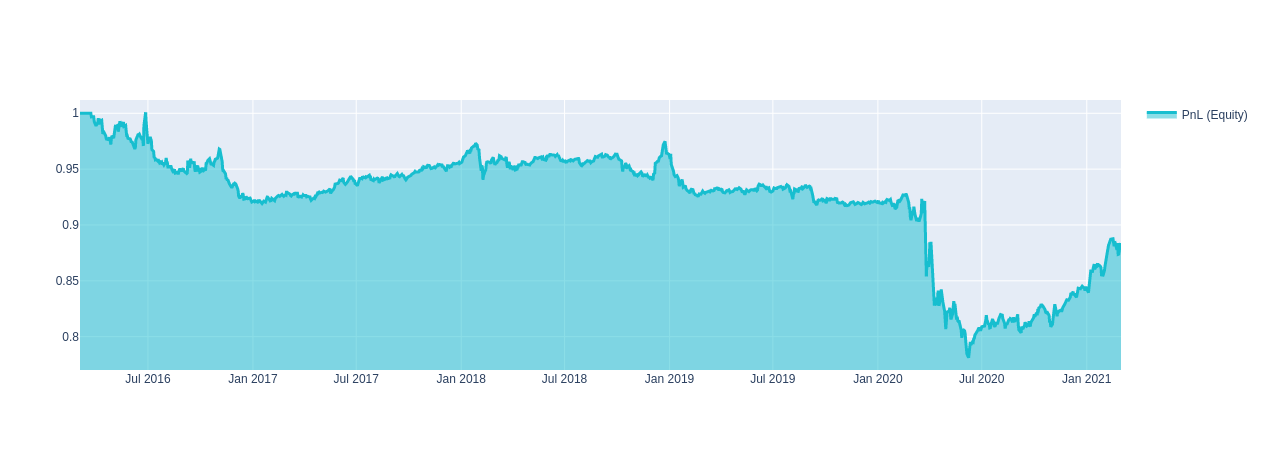

In [5]:
import qnt.graph as qngraph
performance = stats.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)")

# 4. Submit

Once you are satisfied with the quality of your algorithm you can submit it. The algorithm will be processed daily on our servers and it will accumulate a track record on live data. Each contest has a submission phase, during which you can submit code and replace it with new algos, and a live phase, where submissions cannot be replaced and develop a track record.

The **check** function will show **possible problems** that your strategy has:



In [6]:
# check the quality of your strategy
qnout.check(weights, data)

Check liquidity...
Ok.
Check missed dates...
Ok.
Check exposure...
Ok. The exposure check succeed.
Check the sharpe ratio...


WARNING! There are not enough points in the data.
The first data point(2016-03-04) should be earlier than 2015-01-01
WARNING! There are not enough points in the output.
The output series should start from 2015-01-01 or earlier instead of 2016-03-04


Period: 2016-03-04 - 2021-03-02
Sharpe Ratio = -0.449646835346711


ERROR! The sharpe ratio is too low. -0.449646835346711 < 1


Check correlation.

Ok. This strategy does not correlate with other strategies.


The first check is connected to the possible presence of missing values in your algorithm. With the previous call to the **clean function, this problem is automatically solved**.

The second check computes the In-Sample Sharpe ratio of your system. In this case, as the performance is negative, your submission would not be eligible for taking part to a contest. **The In-Sample Sharpe ratio must be larger than 1**.

The third check controls correlation with existing templates and with all systems submitted to previous contests.

If everything is ok, save the portfolio weights that the algorithm generates calling the write function:


In [7]:
# save weights for the competition
qnout.write(weights)

Write output: /root/fractions.nc.gz


# What libraries are available?

Our library makes extensive use of xarray: 

[xarray](http://xarray.pydata.org/en/stable/)

pandas:

[pandas](https://pandas.pydata.org/)

and numpy:

[numpy](https://numpy.org/)

Function definitions can be found in the qnt folder in your private root directory.

```python
# Import basic libraries.
import xarray as xr
import pandas as pd
import numpy as np

# Import quantnet libraries.
import qnt.data    as qndata  # load and manipulate data
import qnt.output as output   # manage output
import qnt.backtester as qnbt # backtester
import qnt.stats   as qnstats # statistical functions for analysis
import qnt.graph   as qngraph # graphical tools
import qnt.ta      as qnta    # indicators library
```

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can dor example use:

! conda install -y scikit-learn

# How to load data?

Stocks:
```python
data= qndata.stocks.load_data(tail = 5*365, dims = ("time", "field", "asset"))
```

Futures:
```python
data= qndata.futures.load_data(tail = 5*365, dims = ("time", "field", "asset"))
```

BTC Futures:
```python
data= qndata.cryptofutures.load_data(tail = 5*365, dims = ("time", "field", "asset"))
```

Cryptocurrencies:
```python
data= qndata.crypto.load_data(tail = 5*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_data(tail=15 * 365, assets=['NASDAQ:AAPL', 'NASDAQ:AMD','NYSE:GM'])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ['NASDAQ:AAPL', 'NASDAQ:AMD','NYSE:GM'])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high = np.log(data.sel(field="high"))
```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas


prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()


```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low = data.sel(field="low") * 1.0
    close = data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr = get_atr(data, days=14)

```

## EMA

```python
prices = data.sel(field="high")
prices_ema = qnta.ema(prices, 15)

```

## TRIX

```python
prices = data.sel(field="high")
prices_trix = qnta.trix(prices, 15)

```

## ADL and EMA

```python
adl = qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema = qnta.ema(adl, 18)

```

# How to get the sharpe ratio?
```python
def get_sharpe(market_data, weights):
    import qnt.stats as qnstats
    rr = qnstats.calc_relative_return(data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe


sharpe = get_sharpe(data, weights)
display(sharpe)
```


# How to optimize parameters?

Below is an example of a simple optimizer for the original strategy.

We **recommend** that you separate the process of finding the optimal parameters from their application.

* you can clone the strategy
* search for optimal parameters in one file
* use them in another file and send them to the competition.

```python
import xarray as xr
import numpy as np

import qnt.ta as qnta
import qnt.data as qndata
import qnt.output as qnout
import qnt.stats as qnstats

import random

random.seed(8)


def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe


def get_strategy(data, sma_slow_period, sma_fast_period):
    close = data.sel(field="close")
    sma_slow = qnta.sma(close, sma_slow_period)
    sma_fast = qnta.sma(close, sma_fast_period)
    weights = xr.where(sma_slow < sma_fast, 1, -1)
    weights = qnout.clean(weights, data)
    return weights


def get_best_params():
    result = {
        'param_1': '',
        'param_2': '',
        'Sharpe Ratio': ''
    }
    sharpe_best = -5000

    data = qndata.stocks.load_data(tail=6 * 365, dims=("time", "field", "asset"))

    for _ in range(0, 50):
        param_1 = random.randrange(5, 100, 1)
        param_2 = random.randrange(10, 100, 1)
        weights = get_strategy(data, param_1, param_2)
        sharpe = get_sharpe(data, weights)
        if sharpe > sharpe_best:
            sharpe_best = sharpe
            result['Sharpe Ratio'] = sharpe_best
            result['param_1'] = param_1
            result['param_2'] = param_2

    return result


best_params = get_best_params()
print('best_macro_params')
display(best_params)

# check the result

data = qndata.stocks.load_data(tail=5 * 365, dims=("time", "field", "asset"))

weights = get_strategy(data, best_params['param_1'], best_params['param_2'])

qnout.check(weights, data)

# save weights for the competition
qnout.write(weights)

# calc stats
stats = qnstats.calc_stat(data, weights)
display(stats.to_pandas().tail())

import qnt.graph as qngraph

performance = stats.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)")
```

# How do I get a list of the top 100 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_data(tail=5 * 365)


def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values


get_best_instruments(data, weights, 100)

```

# How can I check the results for only the top 10 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets = get_best_instruments(data, weights, 10)

data = qndata.stocks.load_data(tail=5 * 365, assets=best_assets)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data)
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph as qngraph

statistics = qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field=["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)


```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data)
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area (**Competition** > **Checking**). If Sharpe ratio is larger than 1 and technical checks are successful, the strategy will go under the **Running** area (**Competition** > **Running**). Otherwise it will be **Filtered** (**Competition** > **Filtered**) and you should inspect error and warning messages.